<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Explore-Ward-in-Districts" data-toc-modified-id="Explore-Ward-in-Districts-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explore Ward in Districts</a></span></li><li><span><a href="#Analyze-Categories" data-toc-modified-id="Analyze-Categories-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze Categories</a></span></li><li><span><a href="#Build-model" data-toc-modified-id="Build-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build model</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear Regression</a></span></li></ul></li><li><span><a href="#Other-city-data" data-toc-modified-id="Other-city-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Other city data</a></span></li><li><span><a href="#Gather-data" data-toc-modified-id="Gather-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Gather data</a></span><ul class="toc-item"><li><span><a href="#Administrative-units-in-Vietnam" data-toc-modified-id="Administrative-units-in-Vietnam-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Administrative units in Vietnam</a></span></li><li><span><a href="#Get-coordinates" data-toc-modified-id="Get-coordinates-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Get coordinates</a></span></li></ul></li></ul></div>

# Import packages

In [316]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder     #Get coordinates by name

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import random
print('Libraries imported.')

Libraries imported.


In [2]:
map_HCM = folium.Map(location=[10.8231, 106.6297], zoom_start=12)
map_HCM

In [3]:
HCM_ward = pd.read_csv('data\\HCMC_phuong.csv')
HCM_ward.head()

,STT,Tên quận/huyện,Tên phường/xã
0,1,Quận 1,Phường Tân Định
1,2,Quận 1,Phường Đa Kao
2,3,Quận 1,Phường Bến Nghé
3,4,Quận 1,Phường Bến Thành
4,5,Quận 1,Phường Nguyễn Thái Bình


In [4]:
HCM_ward.columns = ['Id', 'District', 'Ward']
HCM_ward.drop(columns = ['Id'], inplace = True)

In [5]:
# HCM_ward_coor = HCM_ward
# HCM_ward_coor['Latitude'] = None
# HCM_ward_coor['Longitude'] = None
# for i, r in HCM_ward_coor.iterrows():
#     g = geocoder.komoot('{}, {}, HCMC'.format(r['Ward'], r['District']))
#     r['Latitude'] = g.latlng[0]
#     r['Longitude'] = g.latlng[1]
HCM_ward_coor = pd.read_csv('data\\HCM_ward_coordinates.csv', index_col=0)

In [6]:
HCM_ward_coor.head()

,District,Ward,Latitude,Longitude
0,Quận 1,Phường Tân Định,10.793203,106.690203
1,Quận 1,Phường Đa Kao,10.788476,106.698318
2,Quận 1,Phường Bến Nghé,10.781824,106.697591
3,Quận 1,Phường Bến Thành,10.781824,106.697591
4,Quận 1,Phường Nguyễn Thái Bình,10.768828,106.698797


# Explore Ward in Districts

__Foursquare API__

In [7]:
CLIENT_ID = '20RZWCF3JUQ4XCINO1GDLZG0KI4METBJFRS4EBAXGXSJG205' # your Foursquare ID
CLIENT_SECRET = '32KLYZKQVATIK0TICOFM2APSZBFLHGROBRMQWBDIQCR3YMZN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 20RZWCF3JUQ4XCINO1GDLZG0KI4METBJFRS4EBAXGXSJG205
CLIENT_SECRET:32KLYZKQVATIK0TICOFM2APSZBFLHGROBRMQWBDIQCR3YMZN


In [8]:
def getNearbyVenues(districts, wards, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for district, ward, lat, lng in zip(districts, wards, latitudes, longitudes):
        print(district + ', ' + ward)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            50)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            district,
            ward,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
                             'Ward',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
HCM_venues = getNearbyVenues(districts=HCM_ward_coor['District'],
                             wards = HCM_ward_coor['Ward'],
                                   latitudes=HCM_ward_coor['Latitude'],
                                   longitudes=HCM_ward_coor['Longitude']
                                  )


Quận 1, Phường Tân Định
Quận 1, Phường Đa Kao
Quận 1, Phường Bến Nghé
Quận 1, Phường Bến Thành
Quận 1, Phường Nguyễn Thái Bình
Quận 1, Phường Phạm Ngũ Lão
Quận 1, Phường Cầu Ông Lãnh
Quận 1, Phường Cô Giang
Quận 1, Phường Nguyễn Cư Trinh
Quận 1, Phường Cầu Kho
Quận 12, Phường Thạnh Xuân
Quận 12, Phường Thạnh Lộc
Quận 12, Phường Hiệp Thành
Quận 12, Phường Thới An
Quận 12, Phường Tân Chánh Hiệp
Quận 12, Phường An Phú Đông
Quận 12, Phường Tân Thới Hiệp
Quận 12, Phường Trung Mỹ Tây
Quận 12, Phường Tân Hưng Thuận
Quận 12, Phường Đông Hưng Thuận
Quận 12, Phường Tân Thới Nhất
Quận Thủ Đức, Phường Linh Xuân
Quận Thủ Đức, Phường Bình Chiểu
Quận Thủ Đức, Phường Linh Trung
Quận Thủ Đức, Phường Tam Bình
Quận Thủ Đức, Phường Tam Phú
Quận Thủ Đức, Phường Hiệp Bình Phước
Quận Thủ Đức, Phường Hiệp Bình Chánh
Quận Thủ Đức, Phường Linh Chiểu
Quận Thủ Đức, Phường Linh Tây
Quận Thủ Đức, Phường Linh Đông
Quận Thủ Đức, Phường Bình Thọ
Quận Thủ Đức, Phường Trường Thọ
Quận 9, Phường Long Bình
Quận 9, Phường L

In [10]:
HCM_venues.head()

,District,Ward,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Quận 1,Phường Tân Định,10.793203,106.690203,Cục Gạch,10.792957,106.689020,Vietnamese Restaurant
1,Quận 1,Phường Tân Định,10.793203,106.690203,Bánh canh cua 87,10.794697,106.690917,Vietnamese Restaurant
2,Quận 1,Phường Tân Định,10.793203,106.690203,Cuc Gach Quan,10.790773,106.691795,Vietnamese Restaurant
3,Quận 1,Phường Tân Định,10.793203,106.690203,Tib Vegetarian,10.792703,106.689710,Vegetarian / Vegan Restaurant
4,Quận 1,Phường Tân Định,10.793203,106.690203,Sivananda Yoga Vedanta Center,10.793292,106.688346,Yoga Studio


In [11]:
cols = ['District', 'Ward', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category', 'Venue']

In [12]:
HCM_venues[cols].groupby(['District', 'Ward', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category']).count()

Venue
District         Ward                    Neighborhood Latitude Neighborhood Longitude Venue Category                                 
Huyện Bình Chánh Thị trấn Tân Túc        10.686417             106.570688             Korean Restaurant                             1
                 Xã Bình Chánh           10.667564             106.573290             Bakery                                        1
                                                                                      Café                                          1
                 Xã Bình Hưng            10.727652             106.664915             Deli / Bodega                                 1
                 Xã Phong Phú            10.703348             106.655690             Café                                          1
                                                                                      Furniture / Home Store                        1
                                                                                      Noodle House                                  1
                 Xã Phạm Văn Hai         10.775068             106.544106             Hotel                                         1
                                                                                      Noodle House                                  1
                 Xã Quy Đức              10.648099             106.655216             Art Gallery                                   1
                                                                                      Gym / Fitness Center                          1
                 Xã Vĩnh Lộc A           10.813151             106.578026             Asian Restaurant                              1
                                                                                      Food & Drink Shop                             1
Huyện Củ Chi     Thị trấn Củ Chi         10.975609             106.499711             Arts & Entertainment                          1
                                                                                      Café                                          2
                                                                                      Coffee Shop                                   2
                 Xã An Nhơn Tây          11.087851             106.512388             Flea Market                                   1
                                                                                      Garden Center                                 1
                                                                                      Vietnamese Restaurant                         1
                 Xã An Phú               11.111604             106.506458             Campground                                    1
                 Xã Hòa Phú              10.980042             106.616141             Vietnamese Restaurant                         1
                 Xã Nhuận Đức            11.034297             106.487086             Asian Restaurant                              1
                                                                                      Diner                                         1
                                                                                      Vietnamese Restaurant                         1
                 Xã Phú Mỹ Hưng          11.131095             106.478890             Shop & Service                                1
                 Xã Phước Hiệp           10.989758             106.450899             Café                                          1
                 Xã Phước Thạnh          11.004831             106.431939             Asian Restaurant                              1
                 Xã Phước Vĩnh An        10.984468             106.521695             Asian Restaurant                              1
                                                                                      Café                  

In [13]:
len(HCM_venues['Venue Category'].unique())

166

# Analyze Categories

What is the most categories?

In [14]:
Cat_count = HCM_venues[['Venue Category', 'Venue']].groupby('Venue Category').count().sort_values(by = 'Venue', ascending = False)
Cat_count.head(40)

,Venue
Venue Category,
Café,436
Vietnamese Restaurant,403
Coffee Shop,240
Asian Restaurant,182
Seafood Restaurant,111
Hotel,81
Restaurant,53
Japanese Restaurant,53
Chinese Restaurant,49


Most of venues are Café or Coffee Shop. In Vietnam, they are not much different
<br/><b>We can assume they're the same</b>

In [15]:
target = 'Coffee Shop'

In [16]:
HCM_venues.loc[HCM_venues['Venue Category'] == 'Café', 'Venue Category'] = target

In [17]:
Cat_count = HCM_venues[['Venue Category', 'Venue']].groupby('Venue Category').count().sort_values(by = 'Venue', ascending = False)
Cat_count.head(40)

,Venue
Venue Category,
Coffee Shop,676
Vietnamese Restaurant,403
Asian Restaurant,182
Seafood Restaurant,111
Hotel,81
Japanese Restaurant,53
Restaurant,53
BBQ Joint,49
Chinese Restaurant,49


In [18]:
print('We have {} district'.format(len(HCM_venues['District'].unique())))

We have 22 district


So we can choose category which have  >= 30 venues

In [19]:
Cat_count = Cat_count.reset_index()

In [20]:
Cat_count.columns = ['Category', 'count']

In [21]:
cat_list = list(Cat_count[Cat_count['count']>=30]['Category'])

In [22]:
#cat_list.remove(target)

In [23]:
print('{} categories which occur more than 30 times'.format(len(cat_list)))

20 categories which occur more than 30 times


In [24]:
cat_list

['Coffee Shop',
 'Vietnamese Restaurant',
 'Asian Restaurant',
 'Seafood Restaurant',
 'Hotel',
 'Japanese Restaurant',
 'Restaurant',
 'BBQ Joint',
 'Chinese Restaurant',
 'Diner',
 'Vegetarian / Vegan Restaurant',
 'Dessert Shop',
 'Food Truck',
 'Pizza Place',
 'Hotel Bar',
 'French Restaurant',
 'Bakery',
 'Fast Food Restaurant',
 'Soup Place',
 'Athletics & Sports']

In [25]:
HCM_g = HCM_venues[cols].groupby(['District', 'Ward', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Category']).count()

In [26]:
HCM_g = HCM_g.reset_index()

In [27]:
HCM_g[list(map(lambda x: x in cat_list, HCM_g['Venue Category']))]

,District,Ward,Neighborhood Latitude,Neighborhood Longitude,Venue Category,Venue
1,Huyện Bình Chánh,Xã Bình Chánh,10.667564,106.573290,Bakery,1
2,Huyện Bình Chánh,Xã Bình Chánh,10.667564,106.573290,Coffee Shop,1
4,Huyện Bình Chánh,Xã Phong Phú,10.703348,106.655690,Coffee Shop,1
7,Huyện Bình Chánh,Xã Phạm Văn Hai,10.775068,106.544106,Hotel,1
11,Huyện Bình Chánh,Xã Vĩnh Lộc A,10.813151,106.578026,Asian Restaurant,1
14,Huyện Củ Chi,Thị trấn Củ Chi,10.975609,106.499711,Coffee Shop,4
17,Huyện Củ Chi,Xã An Nhơn Tây,11.087851,106.512388,Vietnamese Restaurant,1
19,Huyện Củ Chi,Xã Hòa Phú,10.980042,106.616141,Vietnamese Restaurant,1
20,Huyện Củ Chi,Xã Nhuận Đức,11.034297,106.487086,Asian Restaurant,1
21,Huyện Củ Chi,Xã Nhuận Đức,11.034297,106.487086,Diner,1


In [34]:
HCM_g

,District,Ward,Neighborhood Latitude,Neighborhood Longitude,Venue Category,Venue
0,Huyện Bình Chánh,Thị trấn Tân Túc,10.686417,106.570688,Korean Restaurant,1
1,Huyện Bình Chánh,Xã Bình Chánh,10.667564,106.573290,Bakery,1
2,Huyện Bình Chánh,Xã Bình Chánh,10.667564,106.573290,Coffee Shop,1
3,Huyện Bình Chánh,Xã Bình Hưng,10.727652,106.664915,Deli / Bodega,1
4,Huyện Bình Chánh,Xã Phong Phú,10.703348,106.655690,Coffee Shop,1
5,Huyện Bình Chánh,Xã Phong Phú,10.703348,106.655690,Furniture / Home Store,1
6,Huyện Bình Chánh,Xã Phong Phú,10.703348,106.655690,Noodle House,1
7,Huyện Bình Chánh,Xã Phạm Văn Hai,10.775068,106.544106,Hotel,1
8,Huyện Bình Chánh,Xã Phạm Văn Hai,10.775068,106.544106,Noodle House,1
9,Huyện Bình Chánh,Xã Quy Đức,10.648099,106.655216,Art Gallery,1


In [62]:
data = HCM_ward_coor.copy()
data.set_index(['District', 'Ward'], inplace = True)

In [63]:
temp = HCM_venues[HCM_venues['Venue Category'] == 'Coffee Shop'][['District', 'Ward', 'Venue Category']].groupby(['District', 'Ward']).count()

In [64]:
data.join(temp).rename({'Venue Category' : 'Coffee Shop'}, axis = 1)

Latitude   Longitude  Coffee Shop
District         Ward                                                       
Quận 1           Phường Tân Định          10.793203  106.690203          9.0
                 Phường Đa Kao            10.788476  106.698318         13.0
                 Phường Bến Nghé          10.781824  106.697591          6.0
                 Phường Bến Thành         10.781824  106.697591          6.0
                 Phường Nguyễn Thái Bình  10.768828  106.698797          7.0
                 Phường Phạm Ngũ Lão      10.766707  106.692001          4.0
                 Phường Cầu Ông Lãnh      10.765459  106.696588          4.0
                 Phường Cô Giang          10.762010  106.693365          NaN
                 Phường Nguyễn Cư Trinh   10.762397  106.686651          4.0
                 Phường Cầu Kho           10.757525  106.688900          4.0
Quận 12          Phường Thạnh Xuân        10.885599  106.668968          NaN
                 Phường Thạnh Lộc         10.878365  106.684510          1.0
                 Phường Hiệp Thành        10.879027  106.637665          NaN
                 Phường Thới An           10.877179  106.653611          1.0
                 Phường Tân Chánh Hiệp    10.867832  106.624835          1.0
                 Phường An Phú Đông       10.854198  106.691075          NaN
                 Phường Tân Thới Hiệp     10.867052  106.642538          2.0
                 Phường Trung Mỹ Tây      10.849895  106.616864          1.0
                 Phường Tân Hưng Thuận    10.840984  106.621874          NaN
                 Phường Đông Hưng Thuận   10.846274  106.631659          2.0
                 Phường Tân Thới Nhất     10.830510  106.611896          NaN
Quận Thủ Đức     Phường Linh Xuân         10.881036  106.770639          NaN
                 Phường Bình Chiểu        10.879889  106.729681          NaN
                 Phường Linh Trung        10.858572  106.784853          NaN
                 Phường Tam Bình          10.867871  106.734823          1.0
                 Phường Tam Phú           10.863108  106.743449          NaN
                 Phường Hiệp Bình Phước   10.848966  106.720622          NaN
                 Phường Hiệp Bình Chánh   10.830028  106.722019          2.0
                 Phường Linh Chiểu        10.854211  106.762681          2.0
                 Phường Linh Tây          10.860650  106.755798          NaN
                 Phường Linh Đông         10.851888  106.745456          2.0
                 Phường Bình Thọ          10.845424  106.766422          5.0
                 Phường Trường Thọ        10.832417  106.756444          1.0
Quận 9           Phường Long Bình         10.869603  106.839603          NaN
                 Phường Long Thạnh Mỹ     10.841414  106.809964          NaN
                 Phường Tân Phú           10.857232  106.802426          NaN
                 Phường Hiệp Phú          10.846762  106.778404          NaN
                 Phường Tăng Nhơn Phú A   10.845510  106.787057          NaN
                 Phường Tăng Nhơn Phú B   10.836027  106.782913          1.0
                 Phường Phước Long B      10.824642  106.775988          NaN
                 Phường Phước Long A      10.825188  106.764733          1.0
                 Phường Trường Thạnh      10.815240  106.825222          NaN
                 Phường Long Phước        10.809376  106.859596          NaN
                 Phường Long Trường       10.804707  106.817297          NaN
                 Phường Phước Bình        10.815778  106.774393          NaN
                 Phường Phú Hữu           10.791714  106.797859          NaN
Quận Gò Vấp      Phường 15                10.851938  106.668944          NaN
                 Phường 13                10.854058  106.658891          NaN
                 Phường 17                10.837529  106.678106          2.0
                 Phường 06                10.847401  106.666720          2.0
                 Phường 16             

In [65]:
for c in cat_list:
    temp = HCM_venues[HCM_venues['Venue Category'] == c][['District', 'Ward', 'Venue Category']].groupby(['District', 'Ward']).count()
    data = data.join(temp).rename({'Venue Category' : c}, axis = 1)

In [68]:
data = data.replace(np.nan, 0).reset_index()

In [69]:
import gc
gc.collect()

11

In [70]:
data.sample(10)

,District,Ward,Latitude,Longitude,Coffee Shop,Vietnamese Restaurant,Asian Restaurant,Seafood Restaurant,Hotel,Japanese Restaurant,Restaurant,BBQ Joint,Chinese Restaurant,Diner,Vegetarian / Vegan Restaurant,Dessert Shop,Food Truck,Pizza Place,Hotel Bar,French Restaurant,Bakery,Fast Food Restaurant,Soup Place,Athletics & Sports
127,Quận 2,Phường Bình Trưng Tây,10.786351,106.764021,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,Quận Tân Bình,Phường 15,10.821628,106.633925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226,Quận 8,Phường 03,10.847401,106.666720,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
114,Quận Phú Nhuận,Phường 02,10.796732,106.686755,16.0,4.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
67,Quận Bình Thạnh,Phường 25,10.804938,106.718247,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
244,Quận Bình Tân,Phường Bình Trị Đông B,10.748754,106.611218,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
205,Quận 5,Phường 05,10.806795,106.713178,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
267,Huyện Củ Chi,Xã Trung Lập Hạ,11.008723,106.470655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,Quận 11,Phường 15,10.773367,106.654863,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,Quận 5,Phường 06,10.364576,107.081774,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [93]:
corr_matrix = data[cat_list].corr()

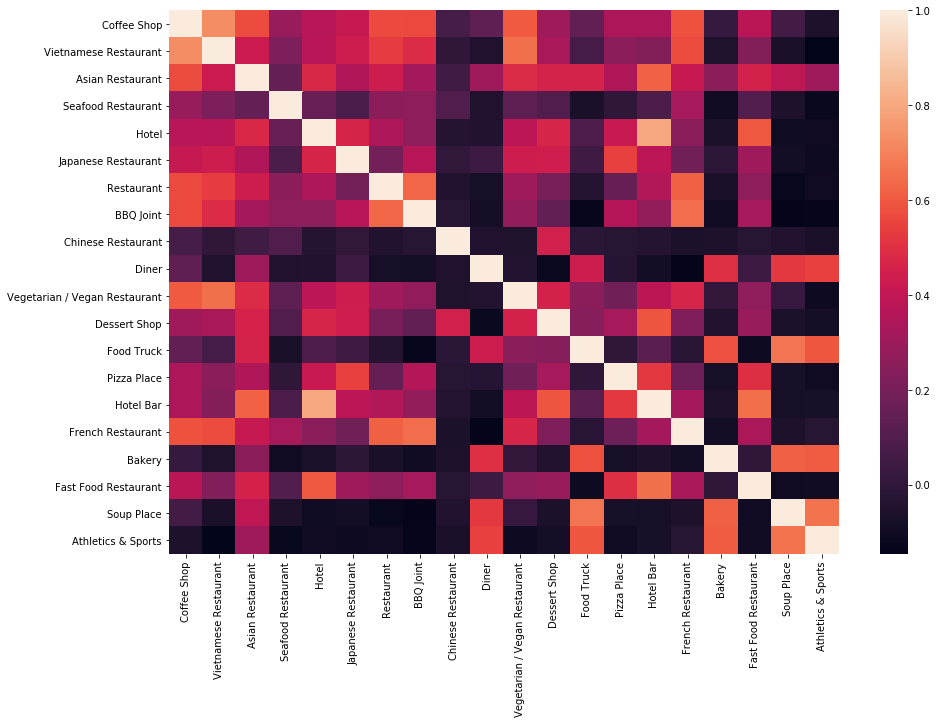

In [94]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix, ax = ax)

In [96]:
corr_matrix.sort_values(by = 'Coffee Shop', ascending = False)['Coffee Shop']

Coffee Shop                      1.000000
Vietnamese Restaurant            0.729142
Vegetarian / Vegan Restaurant    0.604102
French Restaurant                0.584682
Asian Restaurant                 0.571234
Restaurant                       0.568227
BBQ Joint                        0.563527
Japanese Restaurant              0.416393
Fast Food Restaurant             0.382014
Hotel                            0.371305
Hotel Bar                        0.344751
Pizza Place                      0.343462
Dessert Shop                     0.307993
Seafood Restaurant               0.291247
Food Truck                       0.140440
Diner                            0.136527
Chinese Restaurant               0.065700
Soup Place                       0.056653
Bakery                           0.017668
Athletics & Sports              -0.057706
Name: Coffee Shop, dtype: float64

The number of coffee shop high potental variation with Restaurants

# Build model

Try with difference models

In [92]:
from sklearn.model_selection import train_test_split

In [112]:
predict_list = []
del_list = ['Coffee Shop', 'District', 'Ward', 'Latitude', 'Longitude']

In [113]:
for c in data.columns:
    if c not in del_list:
        predict_list.append(c)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.04it/s]


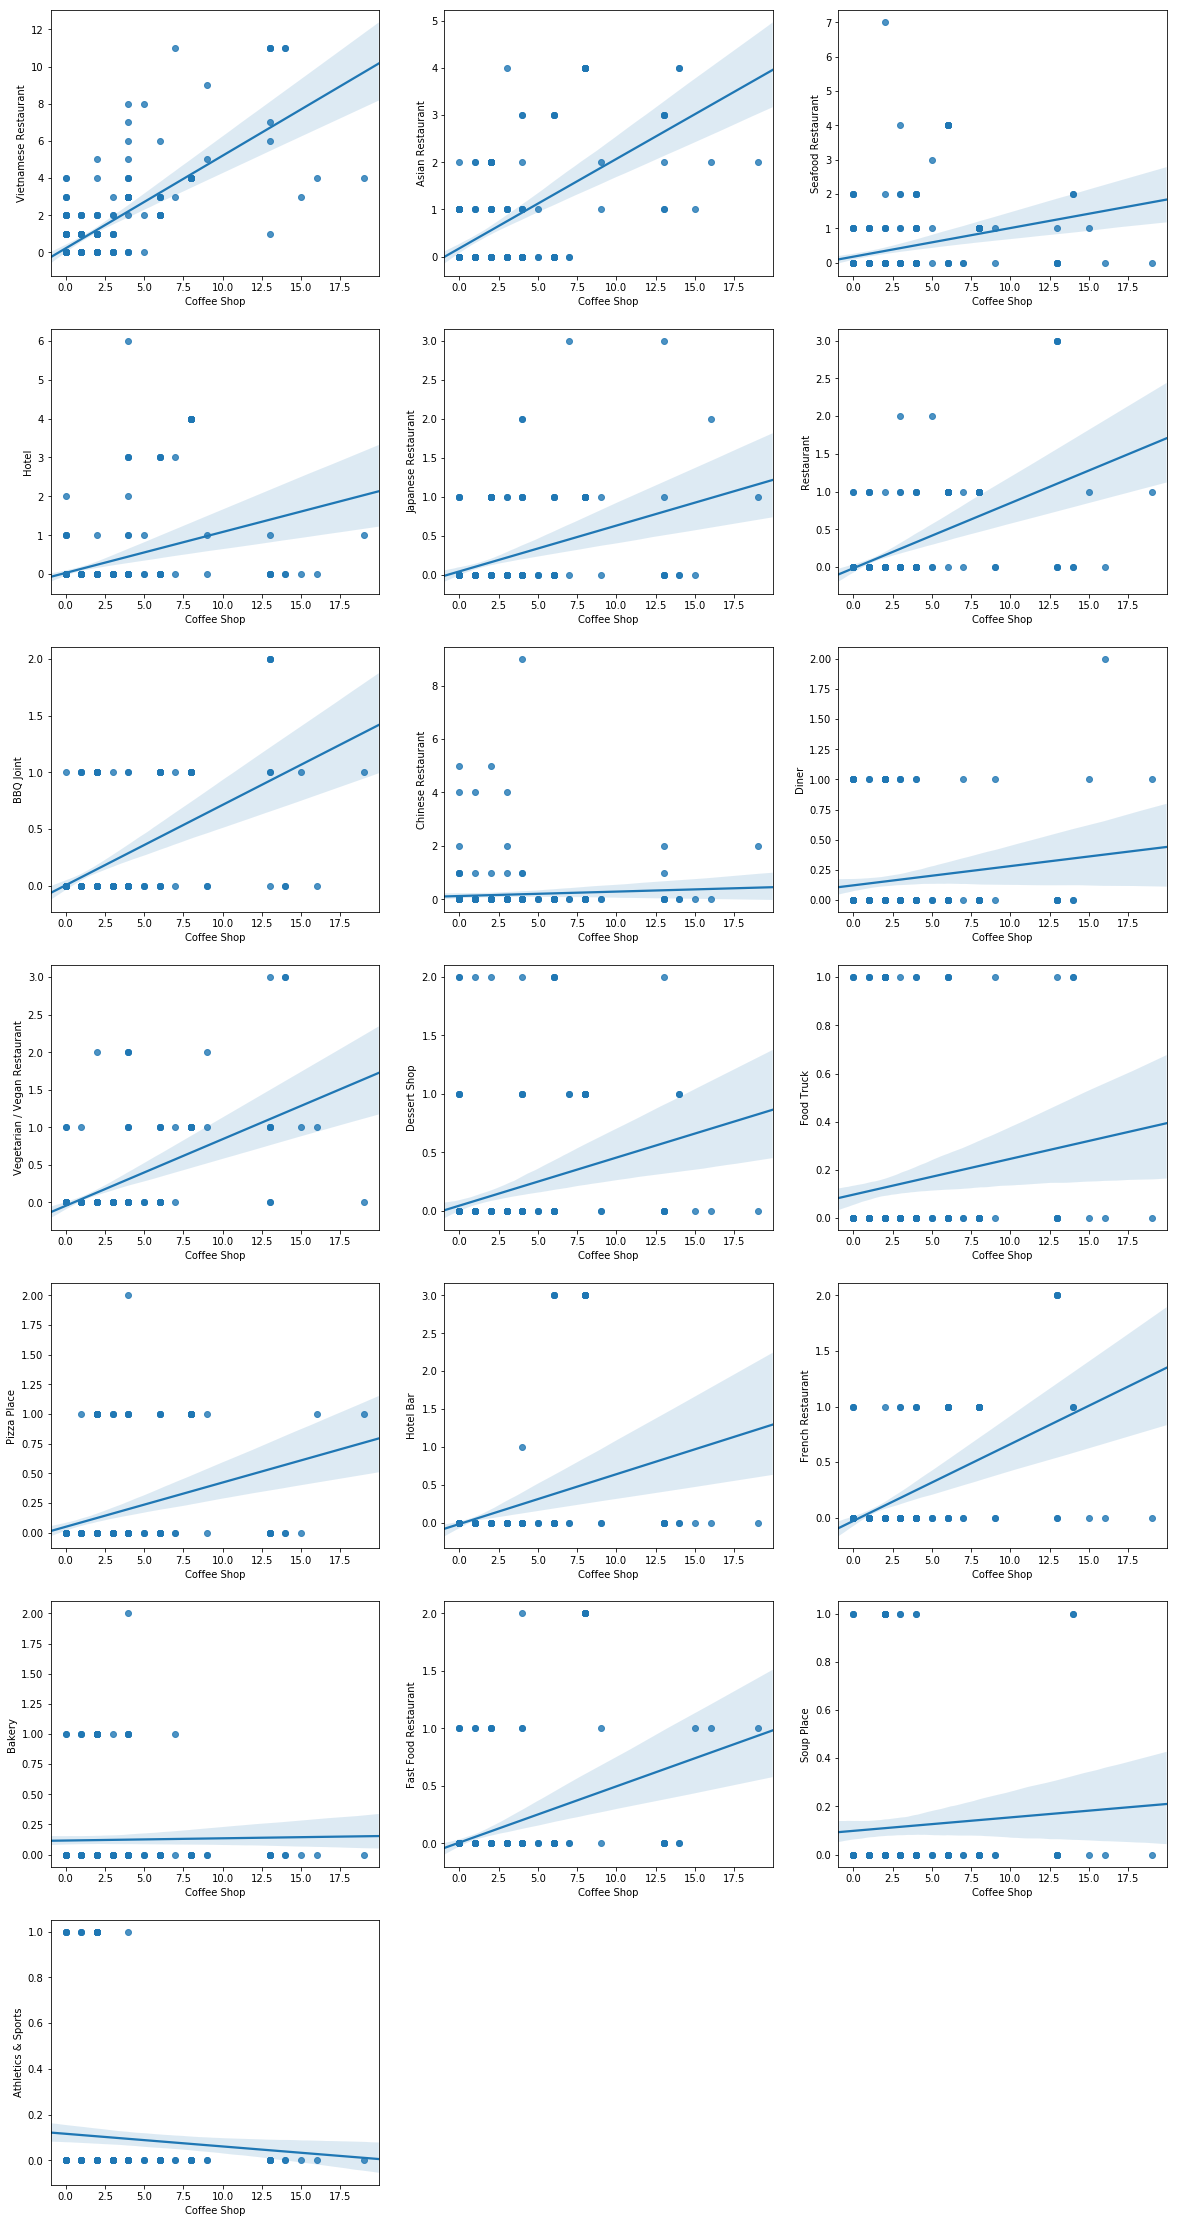

In [224]:
plt.figure(figsize = (20,40))
for i, pred in tqdm(enumerate(predict_list), total = len(predict_list)):
    sns.regplot(data[target], data[pred], ax = plt.subplot2grid((len(predict_list)//3 + 1,3), (i//3,i%3)))

In [115]:
X_train, X_test, y_train, y_test = train_test_split(data[predict_list], data[target], test_size = 0.25, random_state = 1417)

## Linear Regression

In [116]:
from sklearn.linear_model import LinearRegression

In [117]:
lr = LinearRegression()

In [118]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [122]:
lr.coef_

array([ 0.35498611,  0.16932381,  0.28713766, -0.26949953, -0.05133065,
        1.10177561,  0.44005049,  0.10732359,  1.56575444,  2.05362373,
       -0.53704215,  0.87532158,  1.28793939, -0.02476584,  1.10918226,
       -0.84168773,  0.79029021,  0.48820947, -0.68737002])

In [124]:
y_predict = lr.predict(X_test)

In [128]:
from sklearn import metrics

In [138]:
print(metrics.mean_absolute_error(y_test, y_predict))
print(metrics.mean_squared_error(y_test, y_predict))
print(np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

1.33060026592532
6.692669580581537
2.587019439544577


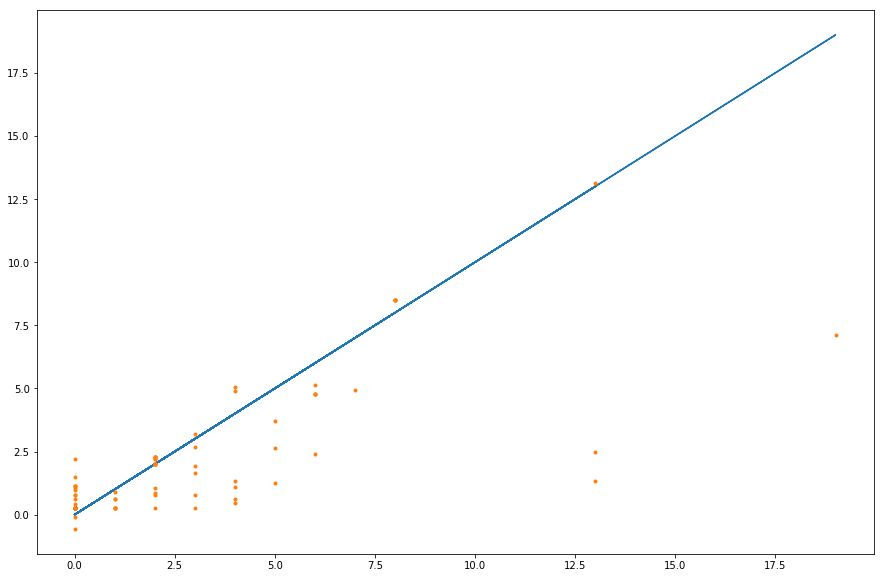

In [169]:
plt.figure(figsize = (15,10))
plt.plot(y_test, y_test, '-')
plt.plot(y_test, y_predict, '.')

it is not fit at all
<br/>Error is high
<br/>**=> Need more data**

# Other city data

# Gather data

## Administrative units in Vietnam

Get administrative units data from https://www.gso.gov.vn/dmhc2015/
<br/>Export to excel file

In [227]:
all_wards = pd.read_excel('data//VN_Administrative_units.xls')

WARNING *** file size (2454899) not 512 + multiple of sector size (512)


In [228]:
all_wards.sample(5)

,Mã,Tên,Tên Tiếng Anh,Cấp,Mã QH,Quận Huyện,Mã TP,Tỉnh / Thành Phố
7815,24277.0,Xã Ea Tul,NaN,Xã,648,Huyện Cư M'gar,66,Tỉnh Đắk Lắk
4780,14947.0,Xã Lương Nội,NaN,Xã,386,Huyện Bá Thước,38,Tỉnh Thanh Hóa
5925,18820.0,Phường Kỳ Trinh,NaN,Phường,449,Thị xã Kỳ Anh,42,Tỉnh Hà Tĩnh
924,1804.0,Xã Thái Cường,NaN,Xã,53,Huyện Thạch An,4,Tỉnh Cao Bằng
4843,15151.0,Xã Cẩm Bình,NaN,Xã,390,Huyện Cẩm Thủy,38,Tỉnh Thanh Hóa


In [232]:
all_wards.rename({'Tên':'Ward', 'Quận Huyện': 'District', 'Tỉnh / Thành Phố':'City'}, axis =1, inplace = True)

In [234]:
all_wards.head()

,Mã,Ward,Tên Tiếng Anh,Cấp,Mã QH,District,Mã TP,City
0,1.0,Phường Phúc Xá,NaN,Phường,1,Quận Ba Đình,1,Thành phố Hà Nội
1,4.0,Phường Trúc Bạch,NaN,Phường,1,Quận Ba Đình,1,Thành phố Hà Nội
2,6.0,Phường Vĩnh Phúc,Vinh Phuc Commune,Phường,1,Quận Ba Đình,1,Thành phố Hà Nội
3,7.0,Phường Cống Vị,NaN,Phường,1,Quận Ba Đình,1,Thành phố Hà Nội
4,8.0,Phường Liễu Giai,Lieu Giai Commune,Phường,1,Quận Ba Đình,1,Thành phố Hà Nội


In [253]:
big_city_mask = (all_wards['City'] == 'Thành phố Hà Nội') | (all_wards['City'] == 'Thành phố Hồ Chí Minh') | ( all_wards['City'] == 'Thành phố Đà Nẵng')

In [319]:
wards = all_wards[big_city_mask][['Ward', 'District', 'City']].reset_index(drop=True)

In [320]:
wards.head()

,Ward,District,City
0,Phường Phúc Xá,Quận Ba Đình,Thành phố Hà Nội
1,Phường Trúc Bạch,Quận Ba Đình,Thành phố Hà Nội
2,Phường Vĩnh Phúc,Quận Ba Đình,Thành phố Hà Nội
3,Phường Cống Vị,Quận Ba Đình,Thành phố Hà Nội
4,Phường Liễu Giai,Quận Ba Đình,Thành phố Hà Nội


In [321]:
wards.shape

(958, 3)

Now we have total 958 wards (data points) in 3 big cities of Vietnam

## Get coordinates

In [328]:
wards['Ward'] = wards['Ward'].str.replace('Phường ', '')
wards['Ward'] = wards['Ward'].str.replace('Xã ', '')
wards['District'] = wards['District'].str.replace('Quận ', '')
wards['District'] = wards['District'].str.replace('Huyện ', '')
wards['City'] = wards['City'].str.replace('Thành phố ', '')

In [329]:
wards['Latitude'] = None
wards['Longitude'] = None
for i, r in tqdm(wards.iterrows(), total = wards.shape[0]):
    try:
        g = geocoder.komoot('{}, {}, {}'.format(r['Ward'], r['District'], r['City']))
        r['Latitude'] = g.latlng[0]
        r['Longitude'] = g.latlng[1]
    except:
        pass
    clear_output(True)

100%|████████████████████████████████████████████████████████████████████████████████| 958/958 [13:12<00:00,  1.21it/s]


In [330]:
#Remove None coordinate wards
wards_df = wards.dropna(axis = 0)

In [331]:
wards_df.to_csv('data\\VN_wards_coordinates.csv')

In [333]:
wards_df.shape

(946, 5)

We have total 946/958 ward coordinates

In [334]:
all_venues = getNearbyVenues(districts=wards_df['District'],
                             wards = wards_df['Ward'],
                                   latitudes=wards_df['Latitude'],
                                   longitudes=wards_df['Longitude']
                                  )


Ba Đình, Phúc Xá
Ba Đình, Trúc Bạch
Ba Đình, Vĩnh Phúc
Ba Đình, Cống Vị
Ba Đình, Liễu Giai
Ba Đình, Nguyễn Trung Trực
Ba Đình, Quán Thánh
Ba Đình, Ngọc Hà
Ba Đình, Điện Biên
Ba Đình, Đội Cấn
Ba Đình, Ngọc Khánh
Ba Đình, Kim Mã
Ba Đình, Giảng Võ
Ba Đình, Thành Công
Hoàn Kiếm, Phúc Tân
Hoàn Kiếm, Đồng Xuân
Hoàn Kiếm, Hàng Mã
Hoàn Kiếm, Hàng Buồm
Hoàn Kiếm, Hàng Đào
Hoàn Kiếm, Hàng Bồ
Hoàn Kiếm, Cửa Đông
Hoàn Kiếm, Lý Thái Tổ
Hoàn Kiếm, Hàng Bạc
Hoàn Kiếm, Hàng Gai
Hoàn Kiếm, Chương Dương
Hoàn Kiếm, Hàng Trống
Hoàn Kiếm, Cửa Nam
Hoàn Kiếm, Hàng Bông
Hoàn Kiếm, Tràng Tiền
Hoàn Kiếm, Trần Hưng Đạo
Hoàn Kiếm, Phan Chu Trinh
Hoàn Kiếm, Hàng Bài
Tây Hồ, Phú Thượng
Tây Hồ, Nhật Tân
Tây Hồ, Tứ Liên
Tây Hồ, Quảng An
Tây Hồ, Xuân La
Tây Hồ, Yên Phụ
Tây Hồ, Bưởi
Tây Hồ, Thụy Khuê
Long Biên, Thượng Thanh
Long Biên, Ngọc Thụy
Long Biên, Giang Biên
Long Biên, Đức Giang
Long Biên, Việt Hưng
Long Biên, Gia Thụy
Long Biên, Ngọc Lâm
Long Biên, Phúc Lợi
Long Biên, Bồ Đề
Long Biên, Sài Đồng
Long Biên, Long 

KeyError: 'groups'

In [336]:
wards_df[wards_df['District'] == 'Thị xã Sơn Tây']

,Ward,District,City,Latitude,Longitude
272,Lê Lợi,Thị xã Sơn Tây,Hà Nội,21.1416,105.506
273,Phú Thịnh,Thị xã Sơn Tây,Hà Nội,10.8654,106.8
274,Ngô Quyền,Thị xã Sơn Tây,Hà Nội,21.1462,105.498
275,Quang Trung,Thị xã Sơn Tây,Hà Nội,10.8527,106.778
276,Sơn Lộc,Thị xã Sơn Tây,Hà Nội,10.869,106.806
278,Đường Lâm,Thị xã Sơn Tây,Hà Nội,10.869,106.806
279,Viên Sơn,Thị xã Sơn Tây,Hà Nội,21.1416,105.506
280,Xuân Sơn,Thị xã Sơn Tây,Hà Nội,10.869,106.806
281,Trung Hưng,Thị xã Sơn Tây,Hà Nội,21.1418,105.504
282,Thanh Mỹ,Thị xã Sơn Tây,Hà Nội,10.869,106.806


In [ ]:
venues_list=[]
for district, ward, lat, lng in zip(districts, wards, latitudes, longitudes):
    print(district + ', ' + ward)

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        500, 
        50)

    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        district,
        ward,
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['District',
                         'Ward',
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

return(nearby_venues)

In [ ]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        21.1416, 
        105.506, 
        500, 
        50)

# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']